# Finite Hypothesis Classes

We are going to go implement some bare-bones supervised machine learning models with finite hypotheses classes on the famous MNIST dataset for handwritten digit recognition, and be able to classify with 90% accuracy between the numbers '1' and '2'. This is a coding complement for the concepts in the first chapter of the 'Learning From Data' textbook (Abu-Mostafa, Magdon-Ismail, Lin), and so we are choosing between '1' and '2' to match the first chapters's assumption of a binary output. Our model can't say anything about the other numbers. 

The MNIST contains input data entries that look like this - user-handwritten numbers, in 28x28 matrices where one cell in the matrix is the pixel of the image, and the value of the cell is the pixel intensity in greyscale, where 0 = black and 255 = white. 

<img title="a title" alt="Alt text" src="/MnistExamplesModified.png">


## Basic setup of the learning model + math 

 Let's see Figure 1.2 in the textbook: 

<img title="a title" alt="Alt text" src="/figure_1.2.png">

In this case, our $X$ will be all possible variations that users can fill out the 28x28 matrix of pixels, and $Y$ is the set of numbers from 0-9. Our training examples of $\{(\vec{x_1}, y_ ), ..., (\vec{x_n}, y_n)\}$ will have a $\vec{x_i}$ be the user input of their handwritten number, and the $y_i$ is the number they are writing. 

We assume there is some ground truth function $f$ that always correctly classifies the handwritten number ($y \in Y$), and we try to choose a $g$ that is classifying the handwriting well enough that we say it approximates $f$ - and what are choosing $g$ out of? The hypothesis class! The hypothesis class is a set of functions, and we go about choosing the final hypothesis with an algorithm that systematically goes through the different hypotheses and chooses the one with the lowest in-sample error. 

Recall that we are using finite hypothesis classes. Specifically, these five: 

1) $H_\text{binary} = \{ \vec{x} \mapsto +1, \vec{x} \mapsto -1 \}$ : this hypothesis class has two hypotheses. The first hypothesis sends all of the inputs to the output -1, and the second hypothesis sends all of the inputs to the output of 1. 
As code:
``` 
H_binary = [lambda x: 1, lambda x: -1]
```

2) $H_\text{axis} = \{ \vec{x} \mapsto \text{sign}(x_i): i \in [d] \}$ : this hypothesis classes has $d$ hypotheses where $d$ is the dimension-of/amount-of-entries-in the inputs $\vec{x} \in X$. If $d$ = 2, then our points will be on the $x_1,x_2$ graph (commonly referred to as the $x, y$ graph) and there will be two hypotheses. The first hypothesis will 'select' the $x_1$-axis ($x$-axis) such that all points above the $x$-axis are 1 and below the $x$-axis are -1. The second hypothesis will select the $x_2$-axis ($y$-axis) such that points to the right are 1, to the left are -1. The concept extends as $d>2$. 
As code: 
```
H_axis = lambda d: [lambda x, i=i: sign(x[i]) for i in range(d)]
```


3) $H_\text{axis2} = \{ \vec{x} \mapsto \sigma \text{sign}(x_i) : \sigma \in \{ 1, -1 \}, i \in [d] \}$ : 
has $2d$ hypotheses. Extending on the example given above, this hypothesis class enables us to choose one axis, but, say for the $x_1$-axis, we can choose points below the $x_1$-axis to be 1 and above to be -1. Thus, we have twice as many hypotheses than in $H_\text{axis}$. 
As code: 
```
H_axis2 = lambda d: [lambda x, i=i, sigma=sigma: sigma * sign(x[i]) for i in range(d) for sigma in [+1, -1]]
```


4) $H_\text{multiaxis2} = \{ \vec{x} \mapsto \text{sign}(\sum_{j=1}^d \sigma_j \text{sign}(x_j)) : \sigma_i \in \{1, -1\}, i \in [d] \}$ : has $2^d$ hypotheses - for each element $x_i$ of the input vector $\vec{x}$, there are two possible choices of weight, either  +1 or  -1 . Since there are $d$ elements, and each can independently take one of two values, the total number of possible combinations, and therefore unique hypotheses, is  $2^d$. 
As code: 
```
H_multiaxis2 = lambda d: [lambda x, sigma=sigma: np.sign(np.sum(sigma * np.sign(x)))
                          for sigma in np.array(np.meshgrid(*[[-1, 1]] * d)).T.reshape(-1, d)]
```


5) $H_\text{multiaxis3} = \{ \vec{x} \mapsto \text{sign}(\sum_{j=1}^d \sigma_j \text{sign}(x_j) ): \sigma_i \in \{1, 0, -1 \}, i \in [d] \} $ : 
has $3^d$ hypotheses - it is similar to the hypothesis above with the only change being that there is an additional weight of '0'. 
As code:
```
H_multiaxis3 = lambda d: [lambda x, sigma=sigma: np.sign(np.sum(sigma * np.sign(x)))
                          for sigma in np.array(np.meshgrid(*[[-1, 0, 1]] * d)).T.reshape(-1, d)]
```


Because our hypothesis classes are finite, we can simply try every hypothesis on our data set and see which hypothesis has the lowest in-sample error - the 'try-everything-algorithm' TEA for $A$ - implementation upcoming below. 

With that, we have finished mapping the different components of the MNIST to this basic learning set-up, and are ready to start coding it up. 

## Part 0: Coding imports + helper functions

This section contains imports and helper functions used by the code in parts 1+.
It is safe to skip reading the code. 

In [1]:
import math
import sklearn
import sklearn.metrics
import time

# make numpy random numbers deterministic
import numpy as np
np.random.seed(0)

# enable plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sign(a):
    '''
    Convert a boolean value into +/- 1.

    >>> sign(12.5)
    1
    >>> sign(-12.5)
    -1
    '''
    if a > 0:
        return 1
    if a <= 0:
        return -1


def set_exp(xs, p):
    '''
    Compute the "set exponential" function.

    For efficiency, this function is a generator.
    This means that large sets will never be explicitly stored,
    and this function will always use O(1) memory.

    The doctests below first convert the generator into a list for visualization.

    >>> list(set_exp([-1, +1], 0))
    []
    >>> list(set_exp([-1, +1], 1))
    [[-1], [1]]
    >>> list(set_exp([-1, +1], 2))
    [[-1, -1], [1, -1], [-1, 1], [1, 1]]
    >>> list(set_exp([-1, +1], 3))
    [[-1, -1, -1], [1, -1, -1], [-1, 1, -1], [1, 1, -1], [-1, -1, 1], [1, -1, 1], [-1, 1, 1], [1, 1, 1]]

    Observe that the length grows exponentially with the power.

    >>> len(list(set_exp([-1, +1], 4)))
    16
    >>> len(list(set_exp([-1, +1], 5)))
    32
    >>> len(list(set_exp([-1, +1], 6)))
    64
    >>> len(list(set_exp([-1, +1], 7)))
    128
    >>> len(list(set_exp([-1, +1], 8)))
    256
    '''
    assert(len(xs) > 0)
    assert(p >= 0)
    assert(type(p) == int)
    if p == 1:
        for x in xs:
            yield [x]
    elif p > 1:
        for x in xs:
            for ys in set_exp(xs, p - 1):
                yield ys + [x]

## Part 1: Hypothesis Classes

We've already translated the mathematical definitions of the finite hypothesis classes into python code above - let us warm up and see how $H_\text{binary}$ and $H_\text{axis}$ act on a simple example vector `x_ex`. 

In [3]:
# The H_binary hypothesis class is easy to represent in code as a list of anonymous functions since there are only 2 functions
H_binary = lambda d: [lambda x: +1, lambda x: -1]
# The code below shows how to use one of these functions on example datapoint x
# Then we apply every hypothesis h in the hypothesis class to the sample.

x_ex = np.array([12.5, -12.5, 1.2, -1.2])

print('H_binary')
print('x_ex = ', x_ex)
# passing in d = 4 since vector x has 4 elements
for h in H_binary(4):
    ypred = h(x_ex)
    print(f'ypred={ypred}')
    
# we're expecting 2 outputs for the 2 functions 

H_binary
x =  [ 12.5 -12.5   1.2  -1.2]
ypred=1
ypred=-1


In [4]:
H_axis = lambda d: [lambda x, i=i: sign(x[i]) for i in range(d)]

x = np.array([12.5, -12.5, 1.2, -1.2])

print('H_axis')
print('x = ', x)
for h in H_axis(4):
    ypred = h(x)
    print(f'ypred={ypred}')

# expecting d outputs

H_axis
x =  [ 12.5 -12.5   1.2  -1.2]
ypred=1
ypred=-1
ypred=1
ypred=-1


In [5]:
# notice that the size of H_binary doesn't change based on the number of dimensions,
# but that the size of H_axis does
print(len(H_binary(5)))
print(len(H_axis(5)))

2
5


We can make a table to see how these different hypothesis classes grow in size as $d$ increases.

In [6]:
H_binary = lambda d: [lambda x: +1, lambda x: -1]
H_axis = lambda d: [lambda x, i=i: sign(x[i]) for i in range(d)]

H_axis2 = lambda d: [lambda x, i=i, sigma=sigma: sigma * sign(x[i]) for i in range(d) for sigma in [+1, -1]]

H_multiaxis2 = lambda d: [lambda x, sigma=sigma: np.sign(np.sum(sigma * np.sign(x)))
                          for sigma in np.array(np.meshgrid(*[[-1, 1]] * d)).T.reshape(-1, d)]


H_multiaxis3 = lambda d: [lambda x, sigma=sigma: np.sign(np.sum(sigma * np.sign(x)))
                          for sigma in np.array(np.meshgrid(*[[-1, 0, 1]] * d)).T.reshape(-1, d)]


# the following code prints a nice table showing the size of the finite hypothesis classes in different dimensions
# you will know your implementations above are correct if the sizes match the formulas we derived in the notes 
print(f'  d {"len(H_binary(d))":>20}{"len(H_axis(d))":>20}{"len(H_axis2(d))":>20}{"len(H_multiaxis2(d))":>25}{"len(H_multiaxis3(d))":>25}')
for d in range(1, 11):
    print(f' {d:2} {len(H_binary(d)):20d}{len(H_axis(d)):20d}{len(H_axis2(d)):20d}{len(H_multiaxis2(d)):25d}{len(H_multiaxis3(d)):25d}')

  d     len(H_binary(d))      len(H_axis(d))     len(H_axis2(d))     len(H_multiaxis2(d))     len(H_multiaxis3(d))
  1                    2                   1                   2                        2                        3
  2                    2                   2                   4                        4                        9
  3                    2                   3                   6                        8                       27
  4                    2                   4                   8                       16                       81
  5                    2                   5                  10                       32                      243
  6                    2                   6                  12                       64                      729
  7                    2                   7                  14                      128                     2187
  8                    2                   8                  16                

## Part 2: Loading the MNIST Data

This section loads the dataset and starts using Scikit-learn and NumPy! 

We're loading the MNIST data such that we directly map images to be vectors in $X$, and outputs to $y$. Notice that we're using capital $X$ as the name of our variable to show that it contains a matrix, and $y$ is a vector. We have a matrix for $X$ because there will be $n$ vectors/inputs with dimension/features-of-inputs $d$, so $X$ is a $n$x$d$ matrix. Meanwhile, $y$ only outputs 1 number, either '1' or '-1', so it has $n$x1 shape. 

The features of $X$ is just each pixel in the image. Our images are 28x28 pixel matrices, so as vectors, the dimension will be 28 $\cdot$ 28 = 784 features. 

In [7]:
# scikit learn has built-in functions for loading lots of standard datasets
# the MNIST dataset is small by machine learning standards,
# but it still takes 10-20 seconds to load on my machine
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy()
y = y.to_numpy()

#print the shape of X and y
print(f"X.shape={X.shape}") # shape = N x d
print(f"y.shape={y.shape}") # shape = N


X.shape=(70000, 784)
y.shape=(70000,)


We will now adjust the dataset so that we can have a binary output by simply looking at how the input vectors in $X$ are labeled in the corresponding $y$ and remove everything that is not a 1 or 2 - thus creating a 'dataset mask', or filter. 

Then, we will change $y$ in place to map '1' and '2' in MNIST to be a '1' or '-1' respectively, to match ch.1 of the textbook. 

In [8]:
#convert MNIST into a binary problem
# the idea is that we will label all "1"s as +1, all "2"s as -1, and delete all the other digits
label_positive = '1'
label_negative = '2'
#logical_or 
dataset_mask = np.logical_or(y == label_positive, y == label_negative)
X = X[dataset_mask]
y = y[dataset_mask]
y[y == label_positive] = +1
y[y == label_negative] = -1
y = y.astype(np.int64)

#print shape of X and y after removing everything that is not a 1 or 2 
print(f"X.shape={X.shape}") # shape = N x d
print(f"y.shape={y.shape}") # shape = N

X.shape=(14867, 784)
y.shape=(14867,)


Now that we've set up our data, let's do a quick sanity check and print out the first 5 entries in our new dataset. Remember that these are images stored as vectors, so we have to reshape it into a matrix again. 

i=0, y[i]=1, x[i]=


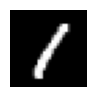

i=1, y[i]=-1, x[i]=


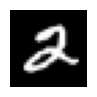

i=2, y[i]=1, x[i]=


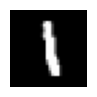

i=3, y[i]=1, x[i]=


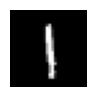

i=4, y[i]=1, x[i]=


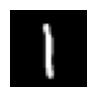

In [9]:
# it's always a good idea to visualize your datapoints after loading them
# this lets us sanity check that our labels are in fact correct
for i in range(5):
    print(f"i={i}, y[i]={y[i]}, x[i]=")
    image = X[i].reshape([28,28])
    fig = plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.show()

Looking good! We had our hypotheses ready, and now we have our data ready. Before we start training the model, we have to set aside some data to verify our model and calculate our $E_test$s for the different hypotheses. We have 14867 inputs. How should we decide how many to use for training vs testing? There are two things that we can find bound for: the generalization error $|E_\text{in}(g) - E_\text{out(g)}$ and $E_\text{test}$. 
1) $|E_\text{in}(g) - E_\text{out(g)} = O(\sqrroot{\frac{\text{log} M - text{log} \delta}{N}})$

In [10]:
# we now split the dataset into training a testing datasets
# we will use a relatively small N value (just to make your future experiments faster)
# we also have a large Ntest value, so we can be fairly confident that |Etest - Eout| is small
N = 1000
Ntest = 10000
Xtrain = X[:N]
ytrain = y[:N]
Xtest = X[N:N+Ntest]
ytest = y[N:N+Ntest]
print(f"Xtrain.shape={Xtrain.shape}")
print(f"ytrain.shape={ytrain.shape}")
print(f"Xtest.shape={Xtest.shape}")
print(f"ytest.shape={ytest.shape}")

Xtrain.shape=(1000, 784)
ytrain.shape=(1000,)
Xtest.shape=(10000, 784)
ytest.shape=(10000,)


## Part 3: Model Training

This section introduces how to implmement and use scikit learn models.
In general, you won't have to implement the more "interesting" models because they are already implemented.
But you will have to implement the TEA model.
The main purpose of this task is to just get you familiar with how scikit learn is structured so that you will be able to effectively use it later on.

In [22]:
# in scikit learn, all learning models are implemented as a class
# these classes are called "estimators",
# and they follow the interface specified in <https://scikit-learn.org/dev/developers/develop.html>
# in particular, all estimators will need at least three methods:
# (1) __init__ specifies the hyperparameters to the model
# (2) fit takes the training dataset as input and computes the hypothesis in the hypothesis class
# (3) predict applies the hypothesis to an input datapoint or dataset

class TEA:
    def __init__(self, H):
        self.H = H
        self.g = None

    def fit(self, X, Y):
        d = X.shape[1]  # dimensionality of the input data
        self.g = self.H(d)[0]
        E_in = np.inf  

        for h in self.H(d):
            h_out = np.apply_along_axis(h,1,X)
            this_E_in = np.mean(h_out != Y)
            if this_E_in < E_in:  
                self.g = h  
                E_in = this_E_in  

        # my results are
        # for H_binary: Ein=0.4710
        # for H_axis: 0.1540
        # for H_axis2: 0.1540
        # you won't be able to use the H_multiaxis2 or H_multiaxis3 hypothesis classes because of the exponential runtimes

    
    def predict(self, X):
        assert(self.g is not None)
        if len(X.shape) == 1:
            return self.g(X)
        else:
            return np.apply_along_axis(self.g, 1, X)

# we now train the model by passing the training data to the .fit method
model = TEA(H_axis) # replace H_axis with other hypothesis classes
time_start = time.time()
model.fit(Xtrain, ytrain)
time_end = time.time()
runtime = time_end - time_start
print(f"runtime={runtime:0.1f} seconds")

# report the relavent metrics
# scikit learn does not have an error metric built in, 
# but we can compute it as 1 - accuracy
ytrain_pred = model.predict(Xtrain)
Ein = 1 - sklearn.metrics.accuracy_score(ytrain_pred, ytrain)
print(f"Ein={Ein:0.4f}")
ytest_pred = model.predict(Xtest)
Etest = 1 - sklearn.metrics.accuracy_score(ytest, ytest_pred)
print(f"Etest={Etest:0.4f}")
print(f'generalization error={abs(Etest - Ein):0.4f}')

runtime=0.5 seconds
Ein=0.1540
Etest=0.1504
generalization error=0.0036


## Part 4: Data preprocessing with random projections

In [24]:
# recall that one of the most important parts of this class is learning how to effectively preprocess data
# in the real world, you will never have to implement your own machine learning algorithms
# existing implementations in libraries like scikit learn are highly optimized,
# and there's no need to reinvent the wheel.
# but you will have to preprocess data

# one of the most important forms of preprocessing is the random projection
# recall that projecting the data onto a smaller dimension (dprime) will cause:
# (1) the runtime for TEA to go down,
# (2) the generalization error |Ein - Eout| to go down,
# (3) the training error Ein to go up
# every application will have different demands on these quantities,
# and so you will have to choose an appropriate dimension dprime for your application

# to project the data, we need to generate a random d x dprime matrix
# we use two tricks to generate the random matrix deterministically:
# first, we set the seed; this ensures that every run of this cell will create the same matrix
# (although the same seed will result in different matrices on different computers)
# second, we create a full matrix and then slice it to the appropriate size
# this ensures that the value of dprime does not affect the contents of A
np.random.seed(0)
d = X.shape[1]
Afull = np.random.uniform(low=-1, high=1, size=(d, d))
print(f'Afull.shape={Afull.shape}') # shape = d x d

Afull.shape=(784, 784)


Xprime.shape=(14867, 13)
i=0, y[i]=1, x[i]=


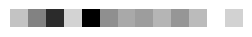

i=1, y[i]=-1, x[i]=


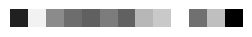

i=2, y[i]=1, x[i]=


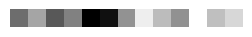

i=3, y[i]=1, x[i]=


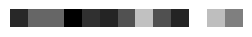

i=4, y[i]=1, x[i]=


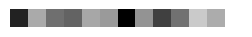

In [34]:
# the code below plots the data points after they have been projected down into a very small dprime
dprime = 13
A = Afull[:, :dprime]
Xprime = X @ A
print(f"Xprime.shape={Xprime.shape}")
for i in range(5):
    print(f"i={i}, y[i]={y[i]}, x[i]=")
    image = Xprime[i].reshape([1, dprime])
    fig = plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.show()

In [35]:
# the images above are no longer human interpretable;
# remarkably, we can still learn an effective hypothesis on these newly transformed data points
# with dprime=5, my results on H_axis2 are nearly as good as they were for the full dataset
# on this smaller dataset size, we can actually now try the H_multiaxis* hypothesis classes as well

model = TEA(H_axis)
time_start = time.time()
model.fit(Xtrain @ A, ytrain)
time_end = time.time()
runtime = time_end - time_start
print(f"runtime={runtime:0.1f} seconds")

ytrain_pred = model.predict(Xtrain @ A)
Ein = 1 - sklearn.metrics.accuracy_score(ytrain_pred, ytrain)
print(f"Ein={Ein:0.4f}")

ytest_pred = model.predict(Xtest @ A)
Etest = 1 - sklearn.metrics.accuracy_score(ytest, ytest_pred)
print(f"Etest={Etest:0.4f}")

print(f'generalization error={abs(Etest - Ein):0.4f}')

runtime=0.0 seconds
Ein=0.1810
Etest=0.1810
generalization error=0.0000


The parameters that were found to have the lowest $E_\text{in}$ was with the $H_\text{axis}$ model and $d = 13$. 

With this size dataset and dimensions, a simple model like $H_\text{axis}$ is likely to prevail as a more complex model like $H_\text{multiaxis}$ may overfit to the dataset - it will have a low $E_\text{in}$, but a high $E_\text{test}$. However, models as simple as $H_\text{binary}$ will not cut it. 

The dimension $d = 13$ was found by simple trial-and-error. 